# Fine tuning T5 on XSum with Truncation of Tokens

Pruning head and tail of sentences to see if accuracy is affected

Sections

1. #### [Baseline Training with T5 and Xsum](#1)
2. #### [Truncating middle tokens with T5 and Xsum](#2)
3. #### [Plotting Loss](#3)
3. #### [Draft](#4)

<a id="1"></a>
# 1. Baseline Training with T5 and Xsum


In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os

# rich: for a better display on terminal
from rich.table import Column, Table
from rich import box
from rich.console import Console

# Importing the T5 modules from huggingface/transformers
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration, tokenization_utils_base

import nltk

from datasets import load_dataset
from datasets import load_metric

#uncomment this if you are not using puffer
# import os
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# !pip3 install datasets
# !pip3 install rich
# !pip3 install SentencePiece
# !pip3 install rouge_score

## Dataset Class

In [2]:
from torch.utils.data import Dataset
import torch
import pandas as pd

class Dataset(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, data, tokenizer, model_name, source_len, target_len, source_text, target_text, #train = True,
    ):
        """
        Initializes a Dataset class

        Args:yo
            data: Input data
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = data
        self.source_len = source_len
        self.summ_len = target_len
        
        # Xsum contains about 200000+ samples, so lets just take a small portion
        self.source_text = self.data[source_text][:1000]
        if "t5" in model_name:
            self.source_text = self.add_prefix(self.source_text)
        self.target_text = self.data[target_text][1:1000]

    def __len__(self):
        """returns the length of data"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }
    
    def add_prefix(self, examples):
        prefix = "summarize: "
        inputs = [prefix + doc for doc in examples]
        return inputs

## Train Function

In [3]:
def train(epoch, tokenizer, model, device, loader, optimizer, scheduler):
    
    """
    Function to be called for training with the parameters passed from main function

    """

    model.train()
    losses = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        if _ % 10 == 0:
            print("STEP: ", _,"/",len(loader))
            training_logger.add_row(str(epoch), str(f'{_}/{len(loader)}'), str(loss))
            console.print(training_logger)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.detach()

    scheduler.step()
    losses = losses/len(loader)
    return losses

## Validation Function

In [4]:
def validate(epoch, tokenizer, model, device, loader):

    """
    Function to evaluate model for predictions

    """
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                  input_ids = ids,
                  attention_mask = mask, 
                  max_length=150, 
                  num_beams=2,
                  repetition_penalty=2.5, 
                  length_penalty=1.0, 
                  early_stopping=True
                  )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _ % 10==0:
                console.print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)

    return predictions, actuals

<hr>

## Rouge Score

In [5]:
from rouge_score import rouge_scorer

def compute_metrics(predictions, actuals, tokenizer):
    
    scorer = rouge_scorer.RougeScorer(['rouge1'])
    
    # a dictionary that will contain the results
    rouge = {'precision': [], 'recall': [], 'fmeasure': []}

    # for each of the hypothesis and reference documents pair
    for (p, a) in zip(predictions, actuals):
        # computing the ROUGE
        score = scorer.score(p, a)
        # separating the measurements
        precision, recall, fmeasure = score['rouge1']
        # add them to the proper list in the dictionary
        rouge['precision'].append(precision)
        rouge['recall'].append(recall)
        rouge['fmeasure'].append(fmeasure)

    return rouge

<hr>

## Trainer Class

In [6]:
def Trainer(
    dataset, source_text, target_text, model_params, output_dir="outputs/", device = "cuda"
):

    """
    trainer

    """
    
    losses = []
    
    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # tokenzier for encoding the text
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    if "bart" in model_params["MODEL"]:
        tokenizer = BartTokenizer.from_pretrained(f'facebook/{model_params["MODEL"]}')
        model = BartForConditionalGeneration.from_pretrained(f'facebook/{model_params["MODEL"]}')
    elif "t5" in model_params["MODEL"]:
        tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
        model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    elif "pegasus" in model_params["MODEL"]:
        tokenizer = PegasusTokenizer.from_pretrained(f'google/{model_params["MODEL"]}')
        model = PegasusForConditionalGeneration.from_pretrained(f'google/{model_params["MODEL"]}')
    else:
        raise ValueError("Undefined model")
        
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Creation of Dataset and Dataloader
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    
    console.print(f"FULL Dataset: {dataset.shape}")
    console.print(f"TRAIN Dataset: {train_dataset.shape}")
    console.print(f"TEST Dataset: {val_dataset.shape}\n")
    
    del dataset
    
    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = Dataset(
        train_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = True,
    )
    val_set = Dataset(
        val_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = False,
    )
    
    del train_dataset, val_dataset
    
    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    print("TRAIN LOADER: ", len(training_loader))
    print("VAL LOADER: ", len(val_loader))
    
    del train_params, val_params
    
    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )
    
    if model_params["SCHEDULER"] == "linear":
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
    
    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    for epoch in range(model_params["TRAIN_EPOCHS"]):

        loss = train(epoch, tokenizer, model, device, training_loader, optimizer, scheduler)
        losses.append(loss.cpu().numpy())

        # evaluating test dataset        
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, f"""predictions_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE TO CSV FINISHED")
        
        
        rouge = compute_metrics(predictions, actuals, tokenizer)
        
        rouge_df = pd.DataFrame.from_dict(rouge, orient='index')
        rouge_df.to_csv(os.path.join(output_dir, f"""rouge_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE ROUGE TO CSV FINISHED")
    
    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    
    # converting list to array
    arr = np.array(losses)
    np.save(os.path.join(output_dir, f"""losses_{model_params['MODEL']}_epoch{model_params['TRAIN_EPOCHS']}"""), arr)

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Completed.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

### Loading Data

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("configured device: ", device)

data = 'xsum'

if data == 'cnn_dailymail':
    dataset = load_dataset(data, '3.0.0')
    source_text = "article"
    target_text = "highlights"
elif data == "xsum":
    dataset = load_dataset(data)
    source_text = "document"
    target_text = "summary"
else:
    raise ValueError("Undefined dataset")

configured device:  cuda


Using custom data configuration default
Reusing dataset xsum (C:\Users\cedri\.cache\huggingface\datasets\xsum\default\1.2.0\32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

## Model Params

In [8]:
# let's define model parameters specific to BART
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE": 8,  # training batch size
    "VALID_BATCH_SIZE": 8,  # validation batch size
    "TRAIN_EPOCHS": 3,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 2e-05,  # learning rate default betas=(0.9, 0.999), eps=1e-08
    "SCHEDULER": "linear",
    "MAX_SOURCE_TEXT_LENGTH": 512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 36,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}

print("===== Ouputs to be saved in =======")
print(os.getcwd() + '\outputs\\')

===== Ouputs to be saved in =======
C:\Program Files (x86)\Projects - Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs\


## Train

In [12]:
console = Console(record=True)

training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

Trainer(
    dataset=dataset,
    source_text=source_text, 
    target_text=target_text,
    model_params=model_params,
    output_dir=os.getcwd() + '\outputs\\',
    device = device,
)

[13:24:20] [Model]: Loading t5-small...          ]8;id=644955;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py\CreatorTemp/ipykernel_12248/3408253027.py]8;;\:]8;id=662091;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py#18\18]8;;\
                                                                                             

[13:24:31] [Data]: Reading data...               ]8;id=450925;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py\CreatorTemp/ipykernel_12248/3408253027.py]8;;\:]8;id=500592;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py#38\38]8;;\
                                                                                             

FULL Dataset: {'train': (204045, 3), 'validation': (11332, 3), 'test': (11334, 3)}

TRAIN Dataset: (204045, 3)

TEST Dataset: (11332, 3)

TRAIN LOADER:  125
VAL LOADER:  125


[13:24:32] [Initiating Fine Tuning]...          ]8;id=724528;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py\CreatorTemp/ipykernel_12248/3408253027.py]8;;\:]8;id=380700;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py#105\105]8;;\
                                                                                             

STEP:  0 / 125


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   | 0/125 | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

STEP:  10 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  20 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  30 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  40 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  50 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  60 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  70 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  80 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  90 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125 | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9074, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9074, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.2607, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9074, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.2607, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 120/125 | tensor(5.0027, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED


[13:41:28] [Saving Model]...                    ]8;id=688728;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py\CreatorTemp/ipykernel_12248/3408253027.py]8;;\:]8;id=742733;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py#126\126]8;;\
                                                                                             

[13:41:29] [Validation Completed.]              ]8;id=63577;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py\CreatorTemp/ipykernel_12248/3408253027.py]8;;\:]8;id=386060;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12248\3408253027.py#138\138]8;;\
                                                                                             

[Model] Model saved @ C:\Program Files (x86)\Projects - 
Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs\model_files

[Validation] Generation on Validation data saved @ C:\Program Files (x86)\Projects - 
Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs\predictions.csv

[Logs] Logs saved @ C:\Program Files (x86)\Projects - 
Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs\logs.txt

In [13]:
print("====================== Done =======================")

====================== Done =======================


In [17]:
import pandas as pd

rouge_df = pd.read_csv('outputs/rouge_t5-small_epoch2.csv')

rouge_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,989,990,991,992,993,994,995,996,997,998
0,precision,0.052632,0.166667,0.133333,0.045455,0.333333,0.120000,0.045455,0.037037,0.136364,...,0.157895,0.200000,0.105263,0.153846,0.137931,0.074074,0.208333,0.115385,0.040000,0.038462
1,recall,0.035714,0.093750,0.100000,0.041667,0.178571,0.142857,0.033333,0.033333,0.053571,...,0.057692,0.111111,0.066667,0.190476,0.088889,0.200000,0.138889,0.100000,0.025641,0.047619
2,fmeasure,0.042553,0.120000,0.114286,0.043478,0.232558,0.130435,0.038462,0.035088,0.076923,...,0.084507,0.142857,0.081633,0.170213,0.108108,0.108108,0.166667,0.107143,0.031250,0.042553


<hr>

<a id="2"></a>
# 2. Truncating middle tokens with T5 and Xsum

Create a dataset class that truncates text data with tokenizer

In [19]:
class Truncate_Dataset(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, data, tokenizer, model_name, source_len, target_len, source_text, target_text, #train = True,
    ):
        """
        Initializes a Dataset class

        Args:yo
            data: Input data
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = data
        self.source_len = source_len
        self.summ_len = target_len
        
        # Xsum contains about 200000+ samples, so lets just take a small portion
        self.source_text = self.data[source_text][:1000]
        if "t5" in model_name:
            self.source_text = self.add_prefix(self.source_text)
        self.target_text = self.data[target_text][1:1000]

    def __len__(self):
        """returns the length of data"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])
        

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        # =====================
        # Beginning truncation
        # select 40% of tokens to the left and 40% to the right of the length of the sentence
        left_remove_percent = .4
        right_remove_percent = .4
        
        left = int(left_remove_percent * len(source.input_ids[0]))
        right = int(right_remove_percent * len(source.input_ids[0]))

        left_selection_ids = source.input_ids[0][:left]
        right_selection_ids = source.input_ids[0][-right:]
        
        
        left_attention_mask = source.attention_mask[0][:left]
        right_attention_mask = source.attention_mask[0][-right:]
        
        new_ids = torch.concat([left_selection_ids, right_selection_ids], 0)        
        new_masks = torch.concat([left_attention_mask,right_attention_mask], 0)
        
        new_ids = new_ids.tolist()
        new_masks = new_masks.tolist()
        
        new_encoding = {
            'input_ids': torch.Tensor([new_ids]),
            'attention_mask': torch.Tensor([new_masks])
        }
        
        # building new encoding
        source = tokenization_utils_base.BatchEncoding(new_encoding)
        
        # =====================
        
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }
    
    def add_prefix(self, examples):
        prefix = "summarize: "
        inputs = [prefix + doc for doc in examples]
        return inputs

In [12]:
def Truncate_Trainer(
    dataset, source_text, target_text, model_params, output_dir="outputs/", device = "cuda"
):

    """
    trainer

    """
    
    losses = []
    
    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # tokenzier for encoding the text
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    if "bart" in model_params["MODEL"]:
        tokenizer = BartTokenizer.from_pretrained(f'facebook/{model_params["MODEL"]}')
        model = BartForConditionalGeneration.from_pretrained(f'facebook/{model_params["MODEL"]}')
    elif "t5" in model_params["MODEL"]:
        tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
        model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    elif "pegasus" in model_params["MODEL"]:
        tokenizer = PegasusTokenizer.from_pretrained(f'google/{model_params["MODEL"]}')
        model = PegasusForConditionalGeneration.from_pretrained(f'google/{model_params["MODEL"]}')
    else:
        raise ValueError("Undefined model")
        
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Creation of Dataset and Dataloader
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    
    console.print(f"FULL Dataset: {dataset.shape}")
    console.print(f"TRAIN Dataset: {train_dataset.shape}")
    console.print(f"TEST Dataset: {val_dataset.shape}\n")
    
    del dataset
    
    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = Truncate_Dataset(
        train_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = True,
    )
    val_set = Truncate_Dataset(
        val_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = False,
    )
    
    del train_dataset, val_dataset
    
    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    print("TRAIN LOADER: ", len(training_loader))
    print("VAL LOADER: ", len(val_loader))
    
    del train_params, val_params
    
    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )
    
    if model_params["SCHEDULER"] == "linear":
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
    
    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    for epoch in range(model_params["TRAIN_EPOCHS"]):

        loss = train(epoch, tokenizer, model, device, training_loader, optimizer, scheduler)
        losses.append(loss.cpu().numpy())

        # evaluating test dataset        
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, f"""head+tail_predictions_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE TO CSV FINISHED")
        
        
        rouge = compute_metrics(predictions, actuals, tokenizer)
        
        rouge_df = pd.DataFrame.from_dict(rouge, orient='index')
        rouge_df.to_csv(os.path.join(output_dir, f"""head+tail_rouge_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE ROUGE TO CSV FINISHED")
    
    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    
    # converting list to array
    arr = np.array(losses)
    np.save(os.path.join(output_dir, f"""head+tail_losses_{model_params['MODEL']}_epoch{model_params['TRAIN_EPOCHS']}"""), arr)

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Completed.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

In [13]:
console = Console(record=True)

training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

Truncate_Trainer(
    dataset=dataset,
    source_text=source_text, 
    target_text=target_text,
    model_params=model_params,
    output_dir=os.getcwd() + '\outputs_with_truncation\\',
    device = device,
)

[18:48:13] [Model]: Loading t5-small...            ]8;id=812513;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py\CreatorTemp/ipykernel_3020/922985184.py]8;;\:]8;id=304328;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py#18\18]8;;\
                                                                                             

[18:48:24] [Data]: Reading data...                 ]8;id=11782;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py\CreatorTemp/ipykernel_3020/922985184.py]8;;\:]8;id=978333;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py#38\38]8;;\
                                                                                             

FULL Dataset: {'train': (204045, 3), 'validation': (11332, 3), 'test': (11334, 3)}

TRAIN Dataset: (204045, 3)

TEST Dataset: (11332, 3)

TRAIN LOADER:  125
VAL LOADER:  125


[18:48:25] [Initiating Fine Tuning]...            ]8;id=513684;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py\CreatorTemp/ipykernel_3020/922985184.py]8;;\:]8;id=82796;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py#105\105]8;;\
                                                                                             

STEP:  0 / 125


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   | 0/125 | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

STEP:  10 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  20 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  30 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  40 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  50 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  60 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  70 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  80 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  90 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125 | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.1950, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.1950, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.3242, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.1950, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.3242, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0791, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.1950, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.3242, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0791, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.8463, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.1950, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.3242, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0791, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.8463, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.2361, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2194, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(5.9434, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.3498, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.2160, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.1416, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.5193, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8637, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.2125, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.9123, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6646, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3036, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.3769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3473, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.5592, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6873, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.6297, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6179, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.3450, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5509, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.6929, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4524, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(5.1404, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.5899, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.8967, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.2942, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.2110, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.2183, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(5.0357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.1824, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2067, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(5.1950, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.3242, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0791, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.8463, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.2361, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 120/125 | tensor(4.9442, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED


[19:01:04] [Saving Model]...                      ]8;id=796988;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py\CreatorTemp/ipykernel_3020/922985184.py]8;;\:]8;id=551305;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py#126\126]8;;\
                                                                                             

[19:01:06] [Validation Completed.]                ]8;id=666860;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py\CreatorTemp/ipykernel_3020/922985184.py]8;;\:]8;id=574056;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_3020\922985184.py#138\138]8;;\
                                                                                             

[Model] Model saved @ C:\Program Files (x86)\Projects - 
Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs_with_truncation\model_files

[Validation] Generation on Validation data saved @ C:\Program Files (x86)\Projects - 
Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs_with_truncation\predictions.csv

[Logs] Logs saved @ C:\Program Files (x86)\Projects - 
Ongoing\AIT\NLP\Project\nlp-ablation-t5\experiments\outputs_with_truncation\logs.txt

In [25]:
print("\n====================== Results with truncation =======================")

import pandas as pd

rouge_df_headtail = pd.read_csv('outputs_with_truncation/head+tail_rouge_t5-small_epoch2.csv')

rouge_df_headtail



====================== Results with truncation =======================


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,989,990,991,992,993,994,995,996,997,998
0,precision,0.052632,0.166667,0.133333,0.045455,0.333333,0.120000,0.045455,0.037037,0.136364,...,0.105263,0.266667,0.105263,0.153846,0.137931,0.074074,0.291667,0.153846,0.040000,0.038462
1,recall,0.037037,0.075000,0.100000,0.041667,0.178571,0.142857,0.043478,0.033333,0.050847,...,0.071429,0.117647,0.064516,0.133333,0.088889,0.200000,0.155556,0.129032,0.025641,0.047619
2,fmeasure,0.043478,0.103448,0.114286,0.043478,0.232558,0.130435,0.044444,0.035088,0.074074,...,0.085106,0.163265,0.080000,0.142857,0.108108,0.108108,0.202899,0.140351,0.031250,0.042553


In [24]:
print("\n====================== Results without (baseline) =======================")

rouge_df


====================== Results without (baseline) =======================


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,989,990,991,992,993,994,995,996,997,998
0,precision,0.052632,0.166667,0.133333,0.045455,0.333333,0.120000,0.045455,0.037037,0.136364,...,0.157895,0.200000,0.105263,0.153846,0.137931,0.074074,0.208333,0.115385,0.040000,0.038462
1,recall,0.035714,0.093750,0.100000,0.041667,0.178571,0.142857,0.033333,0.033333,0.053571,...,0.057692,0.111111,0.066667,0.190476,0.088889,0.200000,0.138889,0.100000,0.025641,0.047619
2,fmeasure,0.042553,0.120000,0.114286,0.043478,0.232558,0.130435,0.038462,0.035088,0.076923,...,0.084507,0.142857,0.081633,0.170213,0.108108,0.108108,0.166667,0.107143,0.031250,0.042553


<hr>

<a id="3"></a>

## Plotting losses

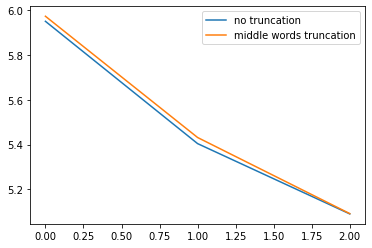

In [38]:
import matplotlib.pyplot as plt
import numpy as np


baseline_loss = np.load('outputs/losses_t5-small_epoch3.npy')
truncate_middle_loss = np.load('outputs_with_truncation/head+tail_losses_t5-small_epoch3.npy')

plt.plot(baseline_loss, label='no truncation')

plt.plot(truncate_middle_loss, label='middle words truncation')
plt.legend()
plt.show()

<hr>

<a id="4"></a>

## Draft Experiments (Random stuff)

In [30]:
### Experiment

sentences = [
    'In Japan, there is no lake bigger than Lake Biwa.',
'Tom\'s apartment is way too big for just one man.',
'Did you hear about the new animal discovered in Ecuador?',
]

tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=10)
print(encoded_input['input_ids'][0])

[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1]


In [32]:
decoded = tokenizer.decode(tokenizer(sentences, padding=True, 
                                      truncation=True, max_length=8)['input_ids'][0])
print(decoded)

In Japan, there is no lake</s>


In [33]:
print("Before=", encoded_input)

Before= {'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1], [3059, 31, 7, 4579, 19, 194, 396, 600, 21, 1], [3963, 25, 1616, 81, 8, 126, 2586, 3883, 16, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [34]:
test = [i for i in range(0,50)]
left = int(.20 * len(test))
right = int(0.70 * len(test))

left_selection = test[:left]
right_selection = test[-right:]
all_indices = left_selection + right_selection
print(all_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [35]:
from transformers import tokenization_utils_base

newdict = {'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1]]}
new_encoding = tokenization_utils_base.BatchEncoding(newdict)

print(new_encoding)

{'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1]]}


In [36]:
a = encoded_input.input_ids[0][0:3]
print(type(a))
a = torch.Tensor(a)
print(type(a))
# after = torch.Tensor([a]) # expected error here

#fix:
a = a.tolist()
after=torch.Tensor([a])



print(after)
after = torch.Tensor([encoded_input.input_ids[0][0:3]])
print(after)
print(type(after))
encoded_input['intput_ids'] = after
print("After:", encoded_input)

<class 'list'>
<class 'torch.Tensor'>
tensor([[  86., 3411.,    6.]])
tensor([[  86., 3411.,    6.]])
<class 'torch.Tensor'>
After: {'input_ids': [[86, 3411, 6, 132, 19, 150, 6957, 4038, 145, 1], [3059, 31, 7, 4579, 19, 194, 396, 600, 21, 1], [3963, 25, 1616, 81, 8, 126, 2586, 3883, 16, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'intput_ids': tensor([[  86., 3411.,    6.]])}
